In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns
import re
import networkx
from datetime import datetime, timedelta
import missingno as msno

In [6]:
columns_to_read = 'B:FO'

In [59]:
df = pd.read_excel("../data/cfpb_updated_tccp.xlsx",skiprows=9,usecols=columns_to_read)

In [60]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Geographic Restrictions,...,Services,Other Services,Rewards,Other Rewards,Card Features,Other Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards,NaN,Chip card,NaN,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,NaN,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,NaN,Yes,NaN,NaN,...,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,NaN,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,NaN,IN; KY; OH,No,Yes,NaN,NaN,...,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,NaN,No,Other. Please Describe:,NaN,...,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [61]:
df.shape

(648, 170)

<Axes: >

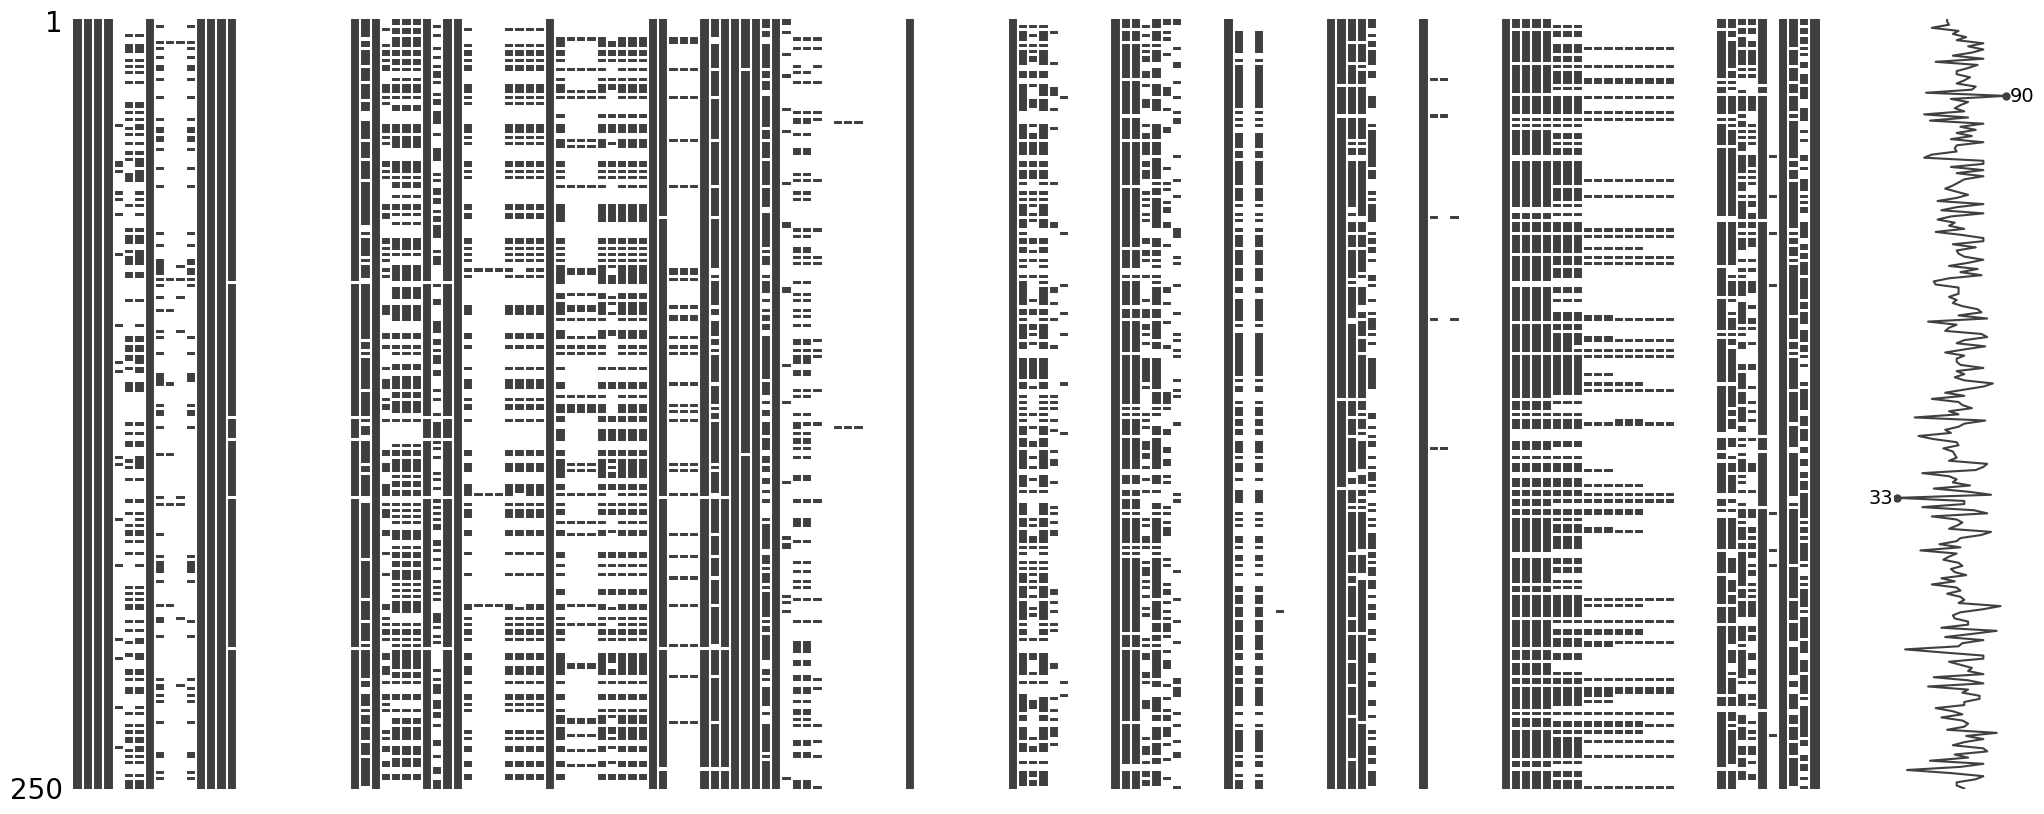

In [62]:
msno.matrix(df.sample(250))

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Columns: 170 entries, Institution Name to Created Date
dtypes: float64(97), object(73)
memory usage: 860.8+ KB


In [64]:
# Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [65]:
type(null_percentage)

pandas.core.series.Series

In [66]:
null_percentage.shape

(170,)

In [67]:
# set threshold
threshold = 90

In [68]:
# Create a list of column names to drop where the null percentage is greater than or equal to the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index.tolist()

In [69]:
len(columns_to_drop)

68

In [70]:
# drop the columns
df.drop(columns=columns_to_drop,inplace=True)

In [71]:
df.shape

(648, 102)

<Axes: >

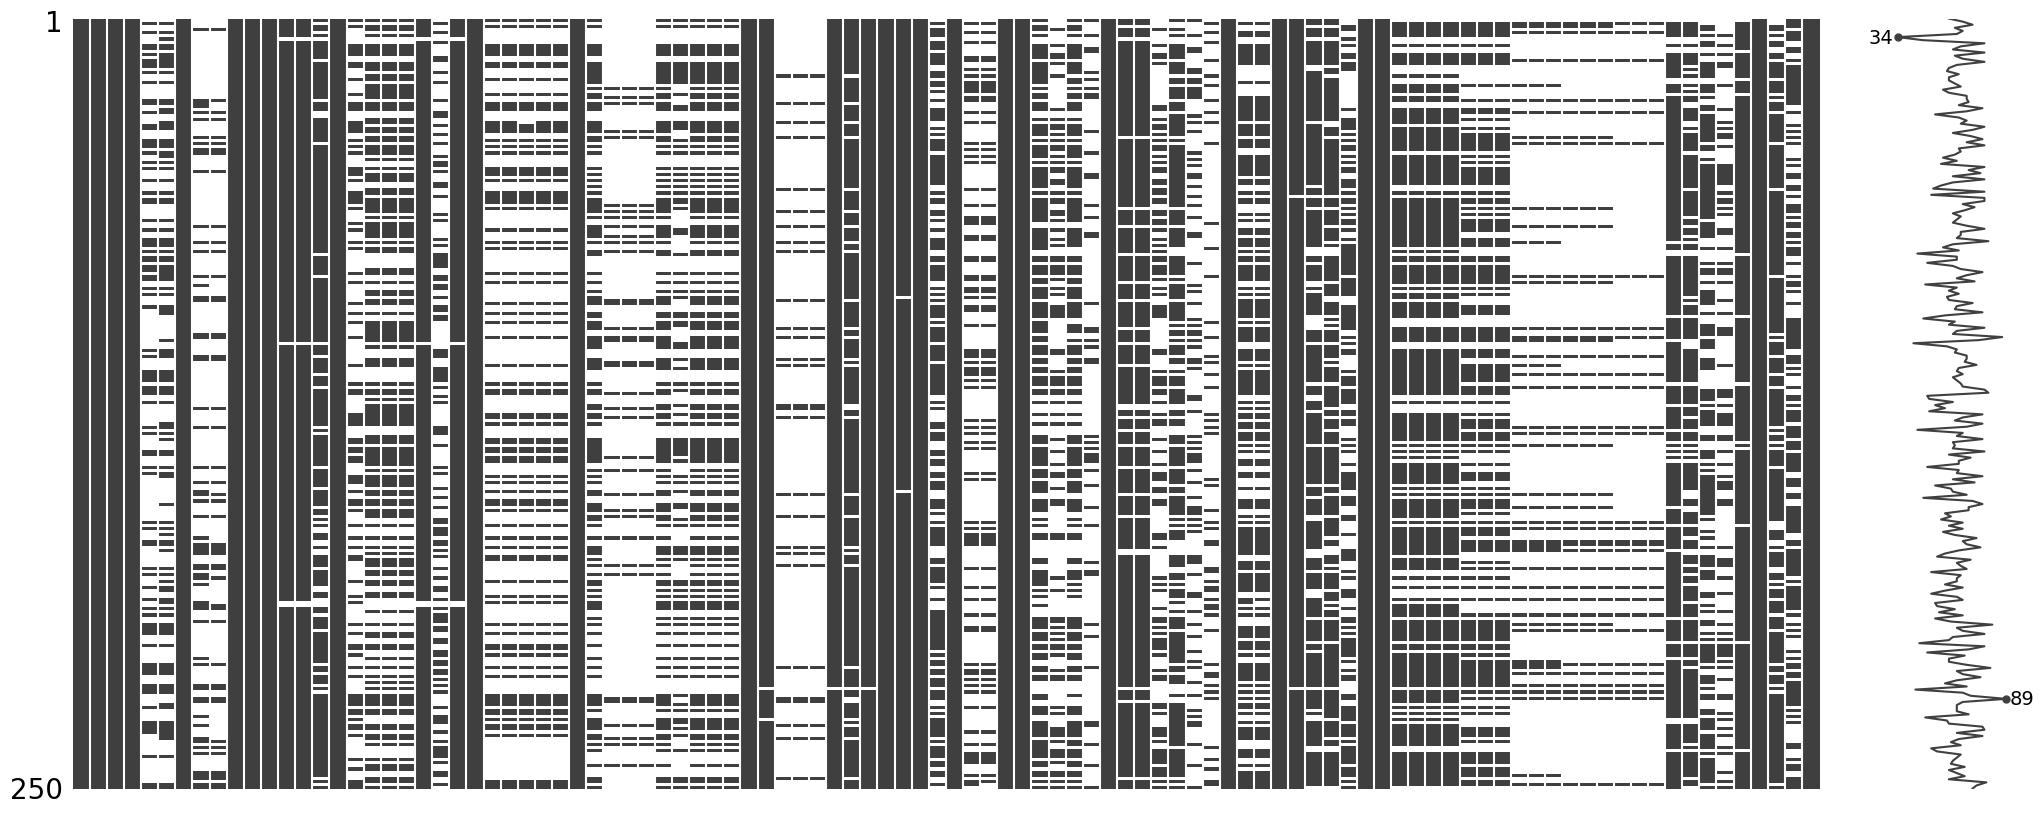

In [72]:
msno.matrix(df.sample(250))

In [73]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Other,Secured Card,...,Other Fee Explanation.4,Services,Other Services,Rewards,Other Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards,NaN,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,IN; KY; OH,No,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,No,Other. Please Describe:,Person must qualify for membership based on th...,No,...,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [74]:
# get remaining column data types
col_types = df.dtypes

In [75]:
# separate out numerical and object columns
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [76]:
df[num_cols].shape

(648, 40)

In [77]:
df[obj_cols].shape

(648, 62)

In [79]:
df[num_cols].isnull().sum().sum(), df[obj_cols].isnull().sum().sum()

(13313, 11087)

In [80]:
# re-Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [88]:
null_percentage.sort_values(ascending=False)[null_percentage >= 59]

Good Credit.3                           89.197531
Great Credit.3                          89.197531
Poor or Fair Credit.3                   89.197531
Other Fee Explanation.4                 88.425926
Other Fee Name.4                        88.425926
Other Fee Amount.4                      88.425926
Other Fee Name.3                        83.796296
Poor or Fair Credit.2                   83.796296
Other Fee Amount.3                      83.796296
Other Fee Explanation.3                 83.796296
Good Credit.2                           83.796296
Great Credit.2                          83.796296
Cash Advance Fee Calculation            81.481481
Other Fee Amount.2                      81.481481
Other Fee Explanation.2                 81.481481
Other Fee Name.2                        81.481481
Other                                   80.555556
Minimum Balance Transfer Fee Amount     80.401235
Requirements for Opening Types          75.000000
Minimum Cash Advance Fee Amount         68.827160


In [89]:
# additional columns to drop
cols_to_drop = null_percentage[null_percentage >= 60].index.tolist()

In [93]:
len(cols_to_drop)

34

In [90]:
# drop additional columns
# drop the columns
df.drop(columns=cols_to_drop,inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 68 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Institution Name                          648 non-null    object 
 1   Product Name                              648 non-null    object 
 2   Report Date                               648 non-null    object 
 3   Availability of Credit Card Plan          648 non-null    object 
 4   Requirements for Opening                  648 non-null    object 
 5   Secured Card                              648 non-null    object 
 6   Targeted Credit Tiers                     648 non-null    object 
 7   Purchase APR Offered?                     648 non-null    object 
 8   Purchase APR Vary by Balance              634 non-null    object 
 9   Purchase APR Index                        634 non-null    object 
 10  Variable Rate Index                   

<Axes: >

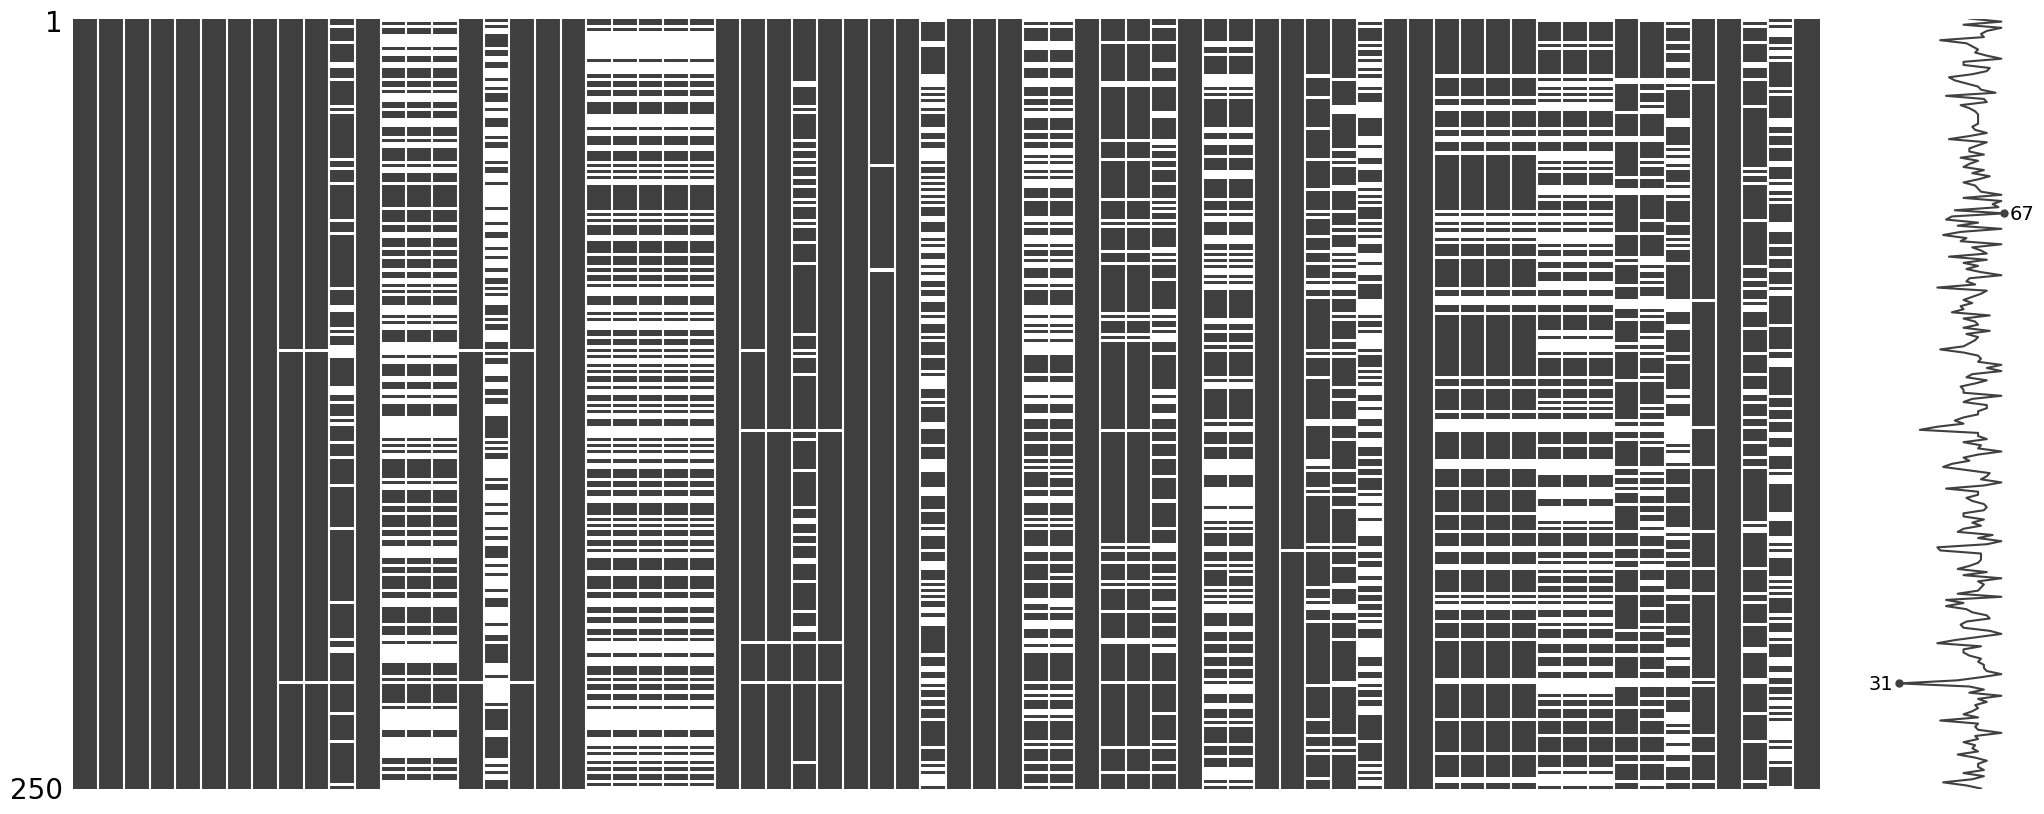

In [94]:
msno.matrix(df.sample(250))

In [96]:
df.columns.shape

(68,)

In [100]:
df.iloc[:5, 0:11]

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Targeted Credit Tiers,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,Good credit (credit scores from 620 to 719),Yes,No,No,NaN
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,Good credit (credit scores from 620 to 719); G...,Yes,No,No,NaN
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,Good credit (credit scores from 620 to 719); G...,Yes,No,Yes,Prime
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,Poor or fair credit (credit score 619 or less)...,No,NaN,NaN,NaN
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,Poor or fair credit (credit score 619 or less)...,Yes,No,No,NaN


In [104]:
df.iloc[:5, 11:21]

,Index,Poor or Fair Credit,Good Credit,Great Credit,Minimum APR,Median APR,Maximum APR,Introductory APR Offered?,Balance Transfer Offered?,Balance Transfer APR Vary by Credit Tier
0,F,NaN,NaN,NaN,0.1490,0.1490,0.1800,No,Yes,No
1,F,NaN,NaN,NaN,0.1150,0.1150,0.1150,No,Yes,No
2,V,NaN,NaN,NaN,0.2099,0.2099,0.2099,No,Yes,No
3,F,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No
4,F,0.159,0.109,0.079,0.0790,NaN,0.1690,No,Yes,Yes


In [105]:
df.iloc[:5, 21:31]

,Minimum APR.2,Maximum APR.2,Median Length of Balance Transfer APR,Balance Transfer Grace Period,Cash Advance APR Offered?,Cash Advance APR Vary by Credit Tier,Minimum APR.3,Median APR.3,Maximum APR.3,Grace Period Offered?
0,0.1490,0.1800,0.0,No,Yes,No,0.1490,0.1490,0.1800,Yes
1,0.1150,0.1150,6.0,Yes,Yes,No,0.1150,0.1150,0.1150,Yes
2,0.2099,0.2099,6.0,Yes,Yes,No,0.2499,0.2499,0.2499,Yes
3,0.1650,0.1650,16.5,No,Yes,No,0.1650,0.1650,0.1650,Yes
4,0.0790,0.1690,6.0,No,Yes,Yes,0.0790,NaN,0.1690,Yes


In [106]:
df.iloc[:5, 31:41]

,Grace Period,Minimum Finance Charge?,Minimum Finance Charge (Dollars),Balance Computation Method,Purchase Transaction Fees,Balance Transfer Fees?,Balance Transfer Fee Types,Balance Transfer Fee (%),Cash Advance Fees?,Cash Advance Fee For Each Transaction
0,25.0,No,NaN,Average daily balance including new purchases,No,Yes,"2. If fee is percentage of transaction amount,...",0.03,Yes,No
1,25.0,Yes,0.01,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN
2,6.0,Yes,0.50,Average daily balance excluding new purchases,No,Yes,"1. If fee is charged in dollars, what is the a...",0.03,Yes,Yes
3,25.0,No,NaN,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN
4,25.0,No,NaN,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN


In [107]:
df.iloc[:5, 41:51]

,Cash Advance Fee Types,Amount (Percent) - Transaction Fee,Foreign Transaction Fees?,Foreign Transaction Fees Types,Foreign Transaction Fee (%),Late Fees?,Late Fee Types,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details
0,2. If the fee is a percentage of transaction a...,0.02,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,1. What is the amount of the first late fee on...,10.0,NaN,NaN
1,NaN,NaN,No,NaN,NaN,No,NaN,NaN,NaN,NaN
2,"1. If the fee is charged in dollars, what is t...",0.03,No,NaN,NaN,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
3,NaN,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,$5.00 or if balance is less than $5.00 then th...
4,NaN,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,"5% of the payment due, minimum $15.00 not to e..."


In [108]:
df.iloc[:5, 51:61]

,Over Limit Fees?,Other Fees,Additional Fees,Other Fee Name,Other Fee Amount,Other Fee Explanation,Other Fee Name.1,Other Fee Amount.1,Other Fee Explanation.1,Services
0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Automobile rental insurance; Credit card regis...
3,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Automobile rental insurance; Other
4,No,Yes,No,Returned Payment Fee,10.0,Whenever a payment is returned for any reason.,NaN,NaN,NaN,Debt cancellation coverage; Other


In [109]:
df.iloc[:5, 61:]

,Other Services,Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,NaN,Cashback rewards,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023
